# Titanic Predictions

This dataset contains information on the passengers aboard the Titanic, and the goal is to predict which passengers survive.

**Table of Contents**
* [Cleaning](#clean)
* [Exploring](#explore)
* [Predicting](#predict)

In [1]:
# import packages
import pandas as pd
import numpy as np
import re

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

%matplotlib inline

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# load dataset
train_df = pd.read_csv("train.csv")

train_df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


<IPython.core.display.Javascript object>

In [3]:
# load dataset
test_df = pd.read_csv("test.csv")

test_df.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


<IPython.core.display.Javascript object>

We are given 2 files:
* `train.csv` contains training data and the result (`Survived`)
* `test.csv` contains the test data on which to make predictions

Both data files have some messy data, so we will need to clean both.

<a id="clean"></a>
## Cleaning data

Explore the dataset to figure out what parts of the data need to be cleaned.

In [4]:
# Combine dataframe to see what data needs to be cleaned
concat_df = pd.concat([train_df, test_df])

concat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


<IPython.core.display.Javascript object>

* `Age` has missing values
* `Cabin` has missing values
* `Fare` has 1 missing value
* `Embarked` has 2 missing values

In [5]:
concat_df = concat_df.set_index("PassengerId").sort_index()
concat_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<IPython.core.display.Javascript object>

* `Name` can be split out by `title`, `first_name`, and `last_name`
  * `last_name` comes first before the comma
  * `title` comes right after the comma
  * `nickname` is in parenthesis (not sure what this other name is)
* `Cabin` can be split somehow
* `Ticket` can be split somehow

In [6]:
concat_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


<IPython.core.display.Javascript object>

* Survival rate is 38%
* Average `Age` is 30, and the distribution is slightly skewed left
* Most passengers have at most 1 sibling/spouse
* Most passengers do not have a parent/child onboard
* `Fare` is suspiciously skewed right (max of \$512 seems too high for 1 passenger)

#### Extract names

In [7]:
# Make column names lower case
concat_df.rename(columns=lambda x: x.lower(), inplace=True)

concat_df.tail(1)

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
PassengerId,,,,,,,,,,,
1309,NaN,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


<IPython.core.display.Javascript object>

In [8]:
# Extract last_name from name
concat_df["last_name"] = concat_df.name.apply(lambda x: x.split(",")[0])

# Check for records without a last name
concat_df[concat_df.last_name.isna()]

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,last_name
PassengerId,,,,,,,,,,,,


<IPython.core.display.Javascript object>

In [9]:
# Extract title from name
concat_df["title"] = concat_df.name.apply(lambda x: x.split(",")[1].split()[0])

# Print all unique titles
print(concat_df.title.unique())

# Check for records without a title
concat_df[concat_df.title.isna()]

['Mr.' 'Mrs.' 'Miss.' 'Master.' 'Don.' 'Rev.' 'Dr.' 'Mme.' 'Ms.' 'Major.'
 'Lady.' 'Sir.' 'Mlle.' 'Col.' 'Capt.' 'the' 'Jonkheer.' 'Dona.']


,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,last_name,title
PassengerId,,,,,,,,,,,,,


<IPython.core.display.Javascript object>

In [10]:
# Check counts for each title
concat_df.groupby("title").count().iloc[:, 0].sort_values(ascending=False)

title
Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Col.           2
Mlle.          2
Major.         2
Jonkheer.      1
Don.           1
the            1
Lady.          1
Sir.           1
Mme.           1
Ms.            1
Capt.          1
Dona.          0
Name: survived, dtype: int64

<IPython.core.display.Javascript object>

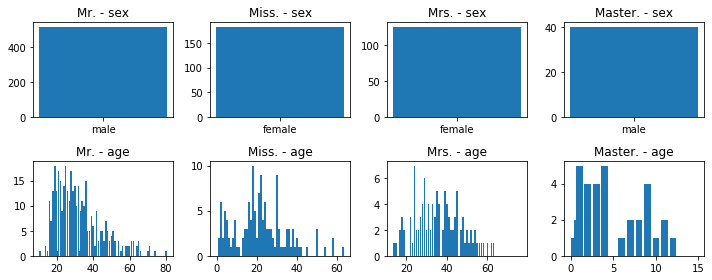

<IPython.core.display.Javascript object>

In [11]:
# Compare against the popular titles (by sex, age)
greater_titles = (
    concat_df.groupby("title").count().iloc[:, 0].sort_values(ascending=False).index[:4]
)

columns = ["sex", "age"]
fig, axes = plt.subplots(2, 4, figsize=[10, 4])

for index, title in enumerate(greater_titles):

    # Filter to title
    p1 = concat_df[concat_df.title == title]

    for i, c in enumerate(columns):

        ax = axes[i, index]

        # Filter out missing values
        p2 = p1[~p1[c].isna()]

        # Count by dimension
        p2 = p2.groupby(c).count().iloc[:, 0].reset_index()
        p2.columns = [c, "counts"]

        ax.bar(x=p2[c], height=p2.counts)
        ax.set_title(f"{title} - {c}")

fig.tight_layout()

* Mr. is male of all ages (mostly 20-30s).
* Master. is young male (under 15 years old).
* Mrs. is female of all ages. Avg age is above 20.
* Miss. is (unmarried) female of all ages but mostly under 40. Avg age is 20.

In [12]:
# Get list of titles not in the top 4
lesser_titles = (
    concat_df.groupby("title").count().iloc[:, 0].sort_values(ascending=False).index[4:]
)

concat_df[concat_df.title.isin(lesser_titles)].sort_values(by="title")

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,last_name,title
PassengerId,,,,,,,,,,,,,
746,0.0,1,"Crosby, Capt. Edward Gifford",male,70.0,1,1,WE/P 5735,71.0000,B22,S,Crosby,Capt.
648,1.0,1,"Simonius-Blumer, Col. Oberst Alfons",male,56.0,0,0,13213,35.5000,A26,C,Simonius-Blumer,Col.
1094,NaN,1,"Astor, Col. John Jacob",male,47.0,1,0,PC 17757,227.5250,C62 C64,C,Astor,Col.
1023,NaN,1,"Gracie, Col. Archibald IV",male,53.0,0,0,113780,28.5000,C51,C,Gracie,Col.
695,0.0,1,"Weir, Col. John",male,60.0,0,0,113800,26.5500,NaN,S,Weir,Col.
31,0.0,1,"Uruchurtu, Don. Manuel E",male,40.0,0,0,PC 17601,27.7208,NaN,C,Uruchurtu,Don.
1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,Oliva y Ocana,Dona.
399,0.0,2,"Pain, Dr. Alfred",male,23.0,0,0,244278,10.5000,NaN,S,Pain,Dr.
797,1.0,1,"Leader, Dr. Alice (Farnham)",female,49.0,0,0,17465,25.9292,D17,S,Leader,Dr.


<IPython.core.display.Javascript object>

* Capt. + Col. are older men (age > 40) → Change to Mr. 
* Don. is male, 40 years old → Change to Mr. 
* Dona. is female, 39 years old → Change to Mrs.
* Dr. is male or female (age 20 - 45) → Change to Mr. or Mrs.
* Jonkheer. is the lowest rank of nobility (his cabin might be A or B) → Change to Mr.
* Lady. is female (48 years old) with 100% survival rate → Change to Mrs. or keep
* Major. is 45-55 male → Change to Mr.
* Mme. and Mlle. are female with 100% survival rate → Change to Mrs. or conform with Lady.
* Ms. is female with unknown age (but "Ms." is used for female when marital status is unknown. She must be at least 20 years old) → Change to Miss.
* Rev. is male of high class with low survival rate  → Change to Mr. or keep Rev.
* Sir. is a high class male (cabin A) → Change to Mr.
* the should be Countess, who is female in 30s and high class → Change to Mrs. or conform with Lady.


In [13]:
# Create cleaned_title field
def clean_title(row):

    title = row.title
    sex = row.sex

    if title in ["Capt.", "Col.", "Don.", "Jonkheer.", "Major.", "Sir."]:
        return "Mr."
    elif title in ["Dona."]:
        return "Mrs."
    elif title in ["Lady.", "Mme.", "Mlle.", "the"]:
        return "Lady."
    elif title in ["Ms."]:
        return "Miss."
    elif title == "Dr." and sex == "male":
        return "Mr."
    elif title == "Dr." and sex == "female":
        return "Mrs."
    else:
        return title


concat_df["title_clean"] = concat_df.apply(lambda x: clean_title(x), axis=1)

# Check if cleaning was successful
concat_df.title_clean.unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Rev.', 'Lady.'], dtype=object)

<IPython.core.display.Javascript object>

In [14]:
# Extract first_name from name
concat_df["first_name"] = concat_df.name.apply(
    lambda x: " ".join(x.split(",")[1].split()[1:])
)

concat_df.head(1)

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,last_name,title,title_clean,first_name
PassengerId,,,,,,,,,,,,,,,
1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S,Braund,Mr.,Mr.,Owen Harris


<IPython.core.display.Javascript object>

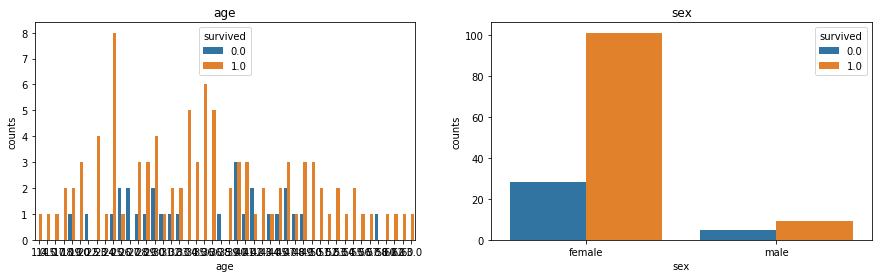

<IPython.core.display.Javascript object>

In [15]:
# Check which names have parenthesis
p1 = concat_df[concat_df.first_name.str.contains("\(")]
columns = ["age", "sex"]
fig, axes = plt.subplots(1, 2, figsize=[15, 4])

for i, c in enumerate(columns):
    ax = axes[i]
    p2 = p1.groupby([c, "survived"]).count().iloc[:, 0].reset_index()
    p2.columns = [c, "survived", "counts"]
    sns.barplot(data=p2, hue="survived", x=c, y="counts", ax=ax)
    ax.set_title(f"{c}")

In [16]:
# Create has_nickname flag (it might be a useful predictor because survivability is high)
concat_df["has_nickname"] = concat_df.first_name.str.contains("\(").astype("int")

<IPython.core.display.Javascript object>

#### Fill in missing ages

Take the average age by each title to fill in the missing ages. Use `title_clean` instead of `title` because there are some raw titles missing age data for its entire group. 

In [17]:
ages = (
    concat_df.groupby("title_clean").mean().age.apply(lambda x: round(x)).reset_index()
)

concat_df = pd.merge(
    concat_df.reset_index(),
    ages,
    left_on="title_clean",
    right_on="title_clean",
    how="left",
    suffixes=("", "_y"),
).set_index("PassengerId")

concat_df["age_clean"] = concat_df["age"].fillna(concat_df["age_y"])
concat_df.drop(["age_y"], axis=1, inplace=True)

concat_df.tail()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,last_name,title,title_clean,first_name,has_nickname,age_clean
PassengerId,,,,,,,,,,,,,,,,,
1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,Spector,Mr.,Mr.,Woolf,0,33.0
1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,Oliva y Ocana,Dona.,Mrs.,Fermina,0,39.0
1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Saether,Mr.,Mr.,Simon Sivertsen,0,38.5
1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,Ware,Mr.,Mr.,Frederick,0,33.0
1309,NaN,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C,Peter,Master.,Master.,Michael J,0,5.0


<IPython.core.display.Javascript object>

#### Extract Cabin

Cabin might be a good predictor because it indicates the floor of the ship (distance from escaping).

In [18]:
def get_cabin_floor(cabin):
    if str(cabin) == "nan":
        return cabin
    else:
        return str(cabin)[0]


concat_df["cabin_floor"] = concat_df.cabin.apply(lambda x: get_cabin_floor(x))

<IPython.core.display.Javascript object>

In [19]:
def get_cabin_room(cabin):
    if str(cabin) == "nan":
        return cabin
    else:
        return cabin.split()[-1:][0][1:]


concat_df["cabin_room"] = concat_df.cabin.apply(lambda x: get_cabin_room(x))
concat_df["cabin_room"] = concat_df["cabin_room"].replace("", np.nan)
concat_df["cabin_room"] = concat_df["cabin_room"].astype("float")
concat_df["has_cabin_info"] = pd.DataFrame(~concat_df.cabin.isna()).astype(int)

<IPython.core.display.Javascript object>

#### Fill in missing fare

Fill in missing fare based on pclass.

In [20]:
# Find which record has missing fare
concat_df[concat_df.fare.isna()]

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,last_name,title,title_clean,first_name,has_nickname,age_clean,cabin_floor,cabin_room,has_cabin_info
PassengerId,,,,,,,,,,,,,,,,,,,,
1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,Storey,Mr.,Mr.,Thomas,0,60.5,NaN,NaN,0


<IPython.core.display.Javascript object>

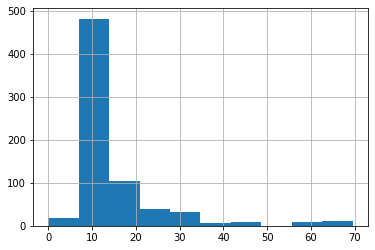

<IPython.core.display.Javascript object>

In [21]:
# Plot distribution
concat_df[concat_df.pclass == 3].fare.hist()

In [22]:
# Since distribution is skewed right, use the median
concat_df.at[1044, "fare"] = concat_df[concat_df.pclass == 3].fare.median()

# Check
concat_df["fare"][1044]

8.05

<IPython.core.display.Javascript object>

#### Fill in missing port (embarked)

Use the port from which the majority of passengers came.

In [23]:
# Find port with highest volume
concat_df.groupby("embarked").count().iloc[:, 0]

embarked
C    168
Q     77
S    644
Name: survived, dtype: int64

<IPython.core.display.Javascript object>

In [24]:
# Fill in missing embarked with "S"
for i in concat_df[concat_df.embarked.isna()].index:
    concat_df.at[i, "embarked"] = "S"

# Check
concat_df[concat_df.embarked.isna()]

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,last_name,title,title_clean,first_name,has_nickname,age_clean,cabin_floor,cabin_room,has_cabin_info
PassengerId,,,,,,,,,,,,,,,,,,,,


<IPython.core.display.Javascript object>

#### Create feature for family members

In [25]:
# Create family_members feature
concat_df["family_members"] = concat_df.sibsp + concat_df.parch

<IPython.core.display.Javascript object>

#### Cleaning data summary

* Extracted title, first name, last name, and nickname-flag from `name`
* Filled in missing ages by using the average `age` for a given title  
* Extracted cabin floor and room from `cabin`
* Filled in missing `fare` by using the median fare price for the given pclass
* Filled in missing `embarked` with the port with highest volume ("S")
* Created feature for `family_members`

<a id="explore"></a>
## Exploring data

**Questions**
* What is survivability by the following factors?
  * `age` (numerical)
  * `sex` (categorical, nominal)
  * `title` (categorical, nominal)
  * `has_nickname` (categorical, nominal)
  * `cabin` (categorical, ordinal)
  * `pclass` (categorical, ordinal)
  * `embarked` (categorical, nominal)
  * `sibsp` (numerical)
  * `parch` (numerical)
  * `family_members` (numerical)
* What is the correlation between these factors (e.g. pclass + cabin)?

In [26]:
# Only use training data for exploratory analysis
explore_df = concat_df[~concat_df.survived.isna()]

<IPython.core.display.Javascript object>

In [27]:
# Create bin for ages and fares
explore_df["age_bin"] = explore_df.apply(lambda x: 5 * round(x.age_clean / 5), axis=1)
explore_df["fare_bin"] = explore_df.apply(
    lambda x: 10 * round(x.age_clean / 10), axis=1
)

/Users/sarinachen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/sarinachen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<IPython.core.display.Javascript object>

Look at survivability and distribution for numerical features.

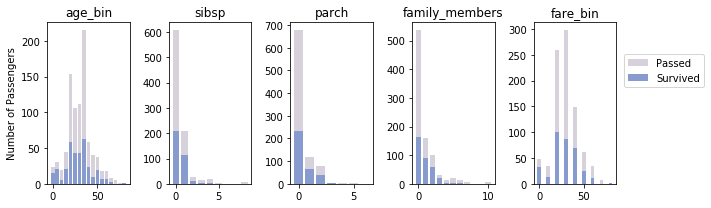

<IPython.core.display.Javascript object>

In [28]:
# Plot distribution with a survival rate breakdown

features = ["age_bin", "sibsp", "parch", "family_members", "fare_bin"]

fig, axes = plt.subplots(1, 5, figsize=[10, 3])

for i, feature in enumerate(features):

    ax = axes[i]

    # Set width
    if feature == "age_bin" or feature == "fare_bin":
        width = 4
    else:
        width = 0.8

    # Plot total (background)
    p = (
        explore_df.groupby(feature)
        .count()
        .iloc[:, 0]
        .reset_index()
        .sort_values(by=feature)
    )
    p.columns = [feature, "counts"]

    ax.bar(x=p[feature], height=p.counts, color="#d7d1db", width=width)

    # Plot survived (overlay with filtered data)
    p = (
        explore_df[explore_df.survived == 1]
        .groupby(feature)
        .count()
        .iloc[:, 0]
        .reset_index()
        .sort_values(by=feature)
    )
    p.columns = [feature, "counts"]

    ax.bar(x=p[feature], height=p.counts, color="#889bcf", width=width)

    # Title
    ax.set_title(feature)

axes[0].set_ylabel("Number of Passengers")
axes[4].legend(["Passed", "Survived"], loc=[1.1, 0.6])

fig.tight_layout()
plt.show()

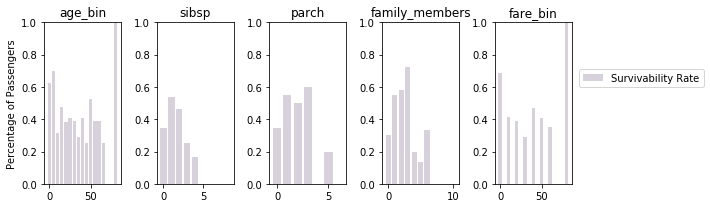

<IPython.core.display.Javascript object>

In [29]:
# Plot survival rate breakdown (because survivability rate was hard to read with the charts above)

features = ["age_bin", "sibsp", "parch", "family_members", "fare_bin"]

fig, axes = plt.subplots(1, 5, figsize=[10, 3])

for i, feature in enumerate(features):

    ax = axes[i]

    # Set width
    if feature == "age_bin" or feature == "fare_bin":
        width = 4
    else:
        width = 0.8

    # Plot survived (overlay with filtered data)
    p = (
        explore_df.groupby(feature)
        .mean()
        .iloc[:, 0]
        .reset_index()
        .sort_values(by=feature)
    )
    p.columns = [feature, "pct"]

    ax.bar(x=p[feature], height=p.pct, color="#d7d1db", width=width)

    # Title
    ax.set_title(feature)
    ax.set_ylim([0, 1])

axes[0].set_ylabel("Percentage of Passengers")
axes[4].legend(["Survivability Rate"], loc=[1.1, 0.6])

fig.tight_layout()
plt.show()

* Most passengers are between ages 20 and 40. Survivability for children is slightly higher than survivability for adults and elderly.
* Most passengers do not have a sibling or spouse (skewed right). However, survivability is greatest when a passenger has 1 or 2 siblings / spouse (likely siblings).
* Most passengers are not accompanied with their parent or child, but survivability is higher when the passenger is with 1 to 3 other family members.

In [30]:
# Create features based on family size
def sort_family(x):
    if x == 0:
        return "alone"
    elif x >= 1 and x <= 3:
        return "small_family"
    else:
        return "big_family"


concat_df["family_size"] = concat_df.family_members.apply(lambda x: sort_family(x))

<IPython.core.display.Javascript object>

Look at survivability for categorical variables.

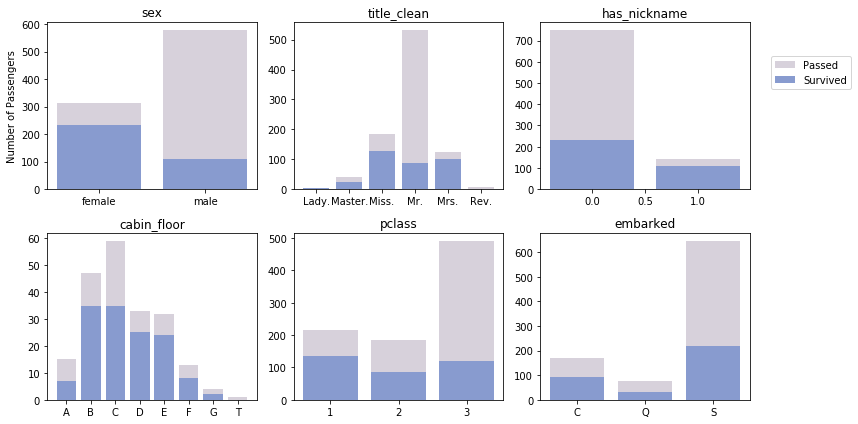

<IPython.core.display.Javascript object>

In [31]:
# Plot distribution with a survival rate breakdown

features = ["sex", "title_clean", "has_nickname", "cabin_floor", "pclass", "embarked"]

fig, axes = plt.subplots(2, 3, figsize=[12, 6])
axes = axes.flatten()


for i, feature in enumerate(features):

    ax = axes[i]

    # Set width
    if feature == "age_bin":
        width = 4
    else:
        width = 0.8

    # Plot total (background)
    p = (
        explore_df.groupby(feature)
        .count()
        .iloc[:, 0]
        .reset_index()
        .sort_values(by=feature)
    )
    p.columns = [feature, "counts"]

    ax.bar(x=p[feature], height=p.counts, color="#d7d1db", width=width)

    # Plot survived (overlay with filtered data)
    p = (
        explore_df[explore_df.survived == 1]
        .groupby(feature)
        .count()
        .iloc[:, 0]
        .reset_index()
        .sort_values(by=feature)
    )
    p.columns = [feature, "counts"]

    ax.bar(x=p[feature], height=p.counts, color="#889bcf", width=width)

    # Title
    ax.set_title(feature)

axes[0].set_ylabel("Number of Passengers")
axes[2].legend(["Passed", "Survived"], loc=[1.1, 0.6])

fig.tight_layout()
plt.show()

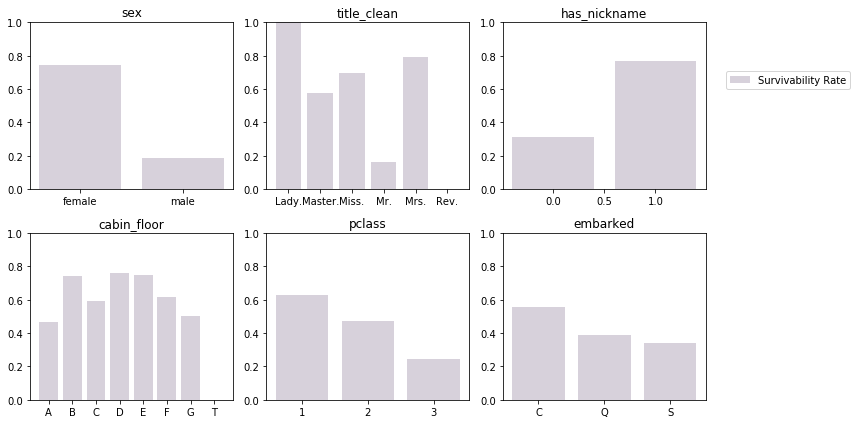

<IPython.core.display.Javascript object>

In [32]:
# Plot survivability rate

features = ["sex", "title_clean", "has_nickname", "cabin_floor", "pclass", "embarked"]

fig, axes = plt.subplots(2, 3, figsize=[12, 6])
axes = axes.flatten()

for i, feature in enumerate(features):

    ax = axes[i]

    p = explore_df.groupby(feature).survived.mean().reset_index()
    p.columns = [feature, "pct"]
    p.sort_values(by=[feature])

    ax.bar(x=p[feature], height=p.pct, color="#d7d1db")

    ax.set_ylim(0, 1)
    ax.set_title(feature)

axes[2].legend(["Survivability Rate"], loc=[1.1, 0.6])
fig.tight_layout()

* There are twice as many males on board, but females are 4 times as likely to survive.
    * For females, the Lady title (high class) has a very high chance of survival (100% with training data).
    * Miss. and Mrs. titles also have high survivability. The Mrs. title has a higher survival rate (possibly because she travels with her family).
    * Master (young) have a high chance of survival.
    * Mr. has a low chance of survival and represents the majority of the male passengers. The Rev. title has a 0% survivability rate, and these men are much older in age.
* Having a nickname helps you survive!
* Cabin floor has some effect on survivability. Cabin floors B, D, and E have the highest chance. Although, further down the alphabet means lower down the ship (according to [wikipedia](https://en.wikipedia.org/wiki/Titanic#:~:text=After%20leaving%20Southampton%20on%2010,11%3A40%20p.m.%20ship's%20time.))
* The richer have higher chance of survival.
* Most passengers embarked at port Southampton (first), which has the lowest survivability. Cherbourg had the highest survivability, although it was the second (middle) stop. Queensland might have been a quick stop, since the number of new passengers was the lowest at this port. The port's correlation with survivability must be related to room assignment because there were at least 3 days for the passengers from the last port to settle in.

Look at correlation between multiple variables.

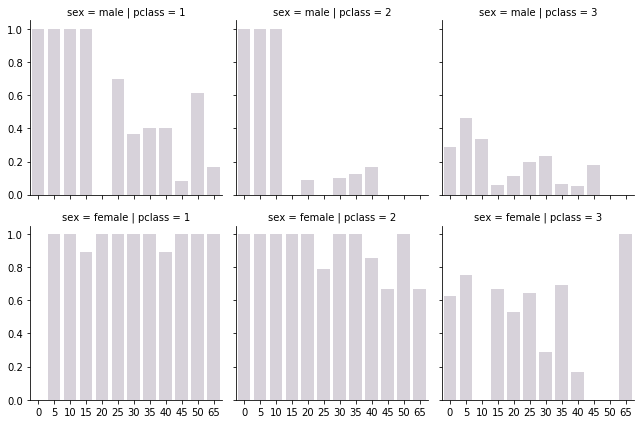

<IPython.core.display.Javascript object>

In [33]:
# Plot survivability by pclass, sex, and age
g = sns.FacetGrid(explore_df, col="pclass", row="sex")
g.map_dataframe(sns.barplot, x="age_bin", y="survived", ci=None, color="#d7d1db")
plt.show()

* Pclass of 3 is just miserable. 
* Females in pclass 1 and 2 have high survivability, but more favorable for the youth.
* Males of pclass 1 and 2 have a high survival rate.

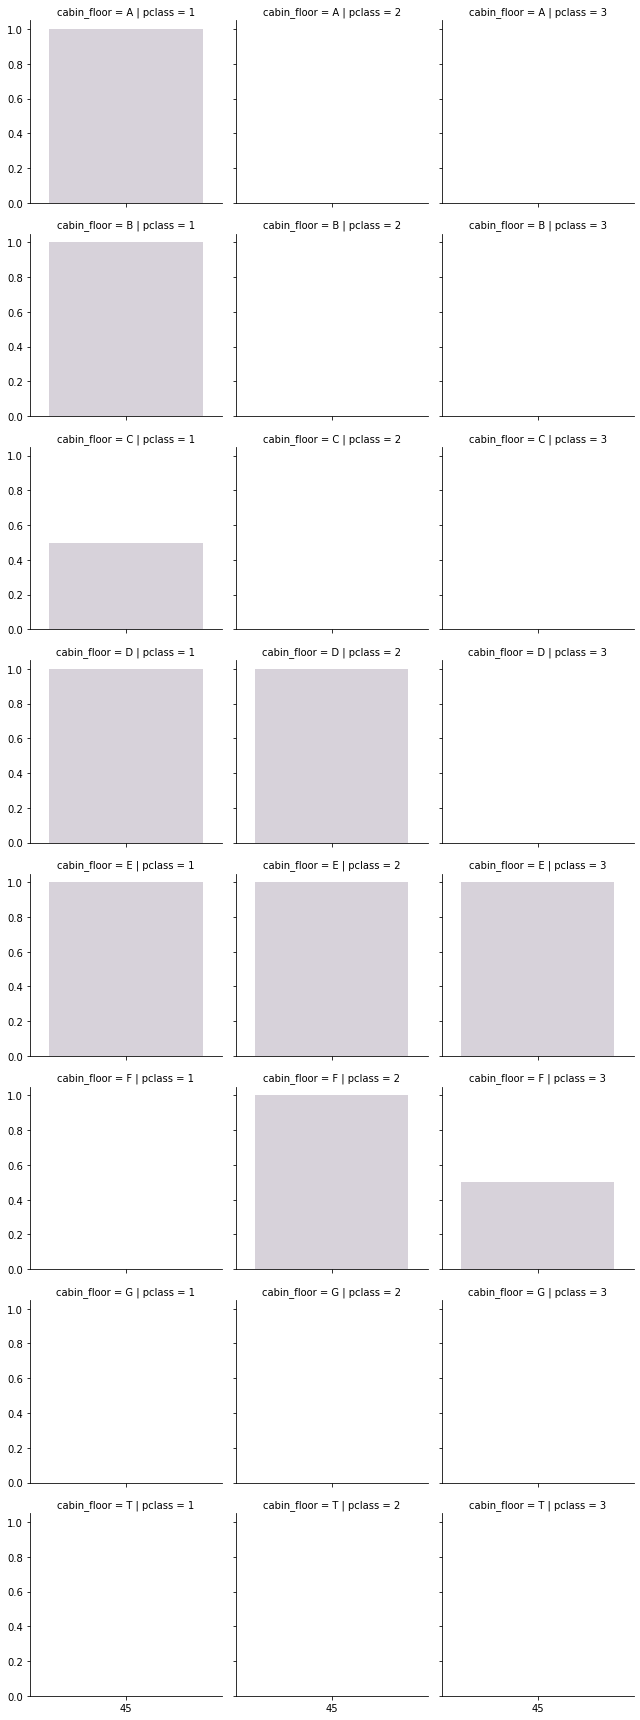

<IPython.core.display.Javascript object>

In [34]:
# Plot survivability by pclass, cabin, and age
p = explore_df[~explore_df.cabin_floor.isna()].sort_values(by="cabin_floor")
g = sns.FacetGrid(p, col="pclass", row="cabin_floor")
g.map_dataframe(sns.barplot, x="age_bin", y="survived", ci=None, color="#d7d1db")
plt.show()

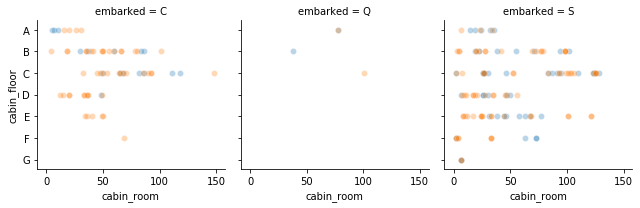

<IPython.core.display.Javascript object>

In [35]:
# Plot survivability by cabin_room, cabin-floor, and embarked (recreate a ship layout)
p = explore_df[explore_df.has_cabin_info == 1].sort_values(
    by=["embarked", "cabin_floor"]
)
g = sns.FacetGrid(p, col="embarked", hue="survived")
g.map(sns.scatterplot, "cabin_room", "cabin_floor", alpha=0.3)
plt.show()

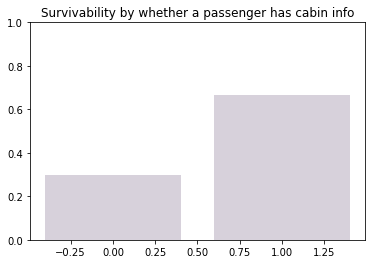

<IPython.core.display.Javascript object>

In [36]:
# Plot survivability by whether a passenger has cabin info (this might be just coincidence)
p = explore_df.groupby("has_cabin_info").survived.mean().reset_index()
p.columns = [feature, "pct"]
p.sort_values(by=[feature])

fig, ax = plt.subplots()
ax.bar(x=p[feature], height=p.pct, color="#d7d1db")
ax.set_title("Survivability by whether a passenger has cabin info")
ax.set_ylim(0, 1)
plt.show()

* Passengers with cabin information are more likely to survive (i.e. a lot of passengers that didn't survive did not have data on which cabin they were in)

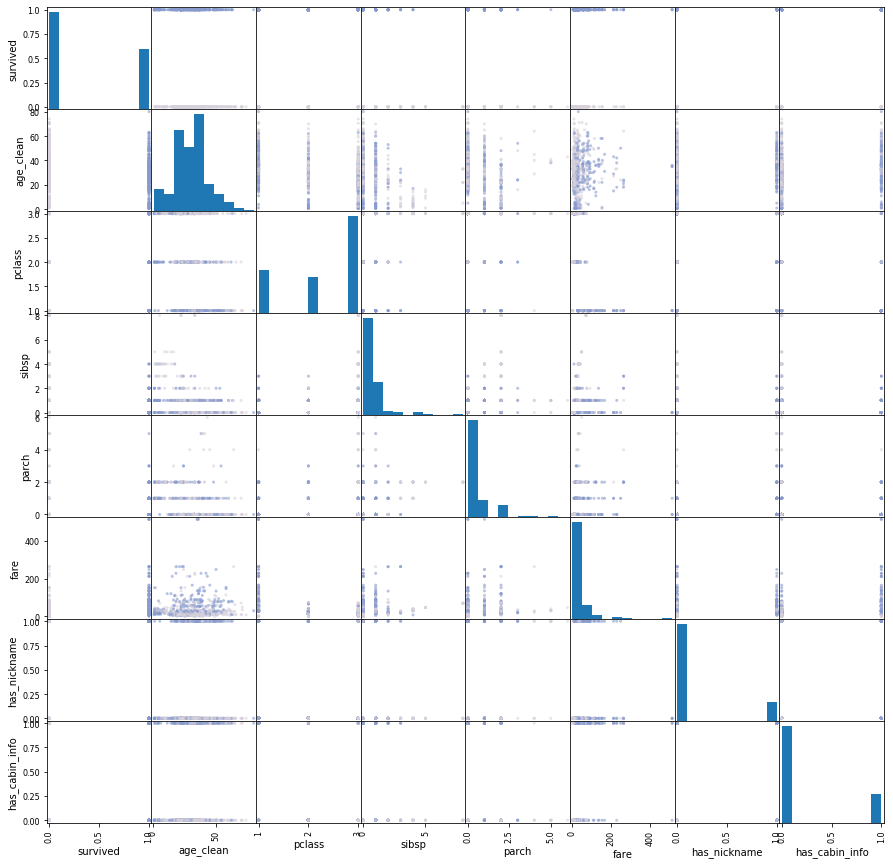

<IPython.core.display.Javascript object>

In [37]:
# Plot scatter matrix (not very helpful)
p = explore_df[
    [
        "survived",
        "age_clean",
        "pclass",
        "sibsp",
        "parch",
        "fare",
        "has_nickname",
        "has_cabin_info",
    ]
]

color_wheel = {0: "#d7d1db", 1: "#889bcf"}
colors = p.survived.map(lambda x: color_wheel.get(x))
scatter_matrix(p, color=colors, alpha=0.6, figsize=(15, 15))
plt.show()

<a id="predict"></a>
## Predicting with data

My training dataset contains 891 records.

Some models to try include logistic regression, random forest, decision tree, and support vector machine. 

In [38]:
# Import more libraries
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn import svm

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    accuracy_score,
    plot_roc_curve,
)

<IPython.core.display.Javascript object>

#### Preparing data

Transform the following categorical variables via one-hot-encoder:
* `title_clean`
* `embarked`
* `sex`
* `cabin_floor`

In [72]:
# Make a copy of DataFrame
df = concat_df.copy()

# Drop unnecessary columns
df.drop(
    [
        "name",
        "first_name",
        "last_name",
        "age",
        "ticket",
        "cabin",
        "title",
        "cabin_room",
        "has_cabin_info",
        "family_members",
        "parch",
        "sibsp",
    ],
    axis=1,
    inplace=True,
)

df.head(1)

,survived,pclass,sex,fare,embarked,title_clean,has_nickname,age_clean,cabin_floor,family_size
PassengerId,,,,,,,,,,
1,0.0,3,male,7.25,S,Mr.,0,22.0,NaN,small_family


<IPython.core.display.Javascript object>

In [73]:
# Rename ports (because cabin_floor and embarked both have "C")
def replace_name(x):
    if x == "S":
        return "Southampton"
    elif x == "C":
        return "Cherbourg"
    elif x == "Q":
        return "Queensland"


df.embarked = df.embarked.apply(lambda x: replace_name(x))

<IPython.core.display.Javascript object>

In [74]:
# encode sex as a binary variable
df["is_male"] = (df.sex == "male").astype("int")

df.drop(["sex"], axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [75]:
# Replace null values in cabin_floor before encoding
df.cabin_floor.fillna("X", inplace=True)
df.cabin_floor.unique()

array(['X', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

<IPython.core.display.Javascript object>

In [76]:
# Encode categorical variables
variables = ["embarked", "title_clean", "cabin_floor", "family_size"]
category_columns = {}

for variable in variables:

    # Factorize
    p = df[variable]
    p_encoded, p_category_names = p.factorize()

    # Add to dictionary to know which columns map to which variables
    category_columns[variable] = list(p_category_names)

    # Add to DataFrame
    df = df.join(
        pd.DataFrame(
            OneHotEncoder().fit_transform(p_encoded.reshape(-1, 1)).toarray(),
            columns=p_category_names,
            index=df.index,
        )
    )

    # Drop column
    df.drop([variable], axis=1, inplace=True)

df.head(1)

,survived,pclass,fare,has_nickname,age_clean,is_male,Southampton,Cherbourg,Queensland,Mr.,...,E,G,D,A,B,F,T,small_family,alone,big_family
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0.0,3,7.25,0,22.0,1,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


<IPython.core.display.Javascript object>

In [77]:
# Check what additional features we have
print(f"Number of categorical features: {df.columns.shape[0]}")
category_columns

Number of categorical features: 27


{'embarked': ['Southampton', 'Cherbourg', 'Queensland'],
 'title_clean': ['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Rev.', 'Lady.'],
 'cabin_floor': ['X', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'],
 'family_size': ['small_family', 'alone', 'big_family']}

<IPython.core.display.Javascript object>

In [78]:
# print columns
df.columns

Index(['survived', 'pclass', 'fare', 'has_nickname', 'age_clean', 'is_male',
       'Southampton', 'Cherbourg', 'Queensland', 'Mr.', 'Mrs.', 'Miss.',
       'Master.', 'Rev.', 'Lady.', 'X', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T',
       'small_family', 'alone', 'big_family'],
      dtype='object')

<IPython.core.display.Javascript object>

In [79]:
# Set up data for modeling
X_train = df.iloc[:891, 1:]
y_train = df.iloc[:891, 0]

<IPython.core.display.Javascript object>

In [80]:
X_train

,pclass,fare,has_nickname,age_clean,is_male,Southampton,Cherbourg,Queensland,Mr.,Mrs.,...,E,G,D,A,B,F,T,small_family,alone,big_family
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,3,7.2500,0,22.0,1,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1,71.2833,1,38.0,0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3,7.9250,0,26.0,0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,53.1000,1,35.0,0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,3,8.0500,0,35.0,1,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,2,13.0000,0,27.0,1,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
888,1,30.0000,0,19.0,0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
889,3,23.4500,0,22.0,0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


<IPython.core.display.Javascript object>

### Logistic Regression

In [81]:
# Set up Log Reg
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Print Scores
tn, fp, fn, tp = confusion_matrix(y_train, log_reg.predict(X_train)).ravel()
score = (tn + tp) / np.sum([tn, fp, fn, tp])
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)
print(f"Score: {round(score*100, 1)}%")
print(f"Precision: {round(precision*100, 1)}%")
print(f"Recall: {round(recall*100, 1)}%")
print(f"F1: {round(f1*100, 1)}%")

Score: 84.1%
Precision: 79.9%
Recall: 78.1%
F1: 79.0%


/Users/sarinachen/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


<IPython.core.display.Javascript object>

In [82]:
# See coefficients of logistic regression (i.e. the weight of each feature)
coeff_df = pd.DataFrame(X_train.columns)
coeff_df.columns = ["Feature"]
coeff_df["Correlation"] = pd.Series(log_reg.coef_[0])

coeff_df.sort_values(by="Correlation", ascending=False)

,Feature,Correlation
11,Master.,1.478515
24,alone,1.329440
23,small_family,0.998916
2,has_nickname,0.959861
16,E,0.920991
10,Miss.,0.813070
18,D,0.717081
9,Mrs.,0.633825
6,Cherbourg,0.466314
7,Queensland,0.430940


<IPython.core.display.Javascript object>

This confirms some trends we already know:
* Men (with the title `Mr.`) have low chances of surviving.
* The lower a passenger's `pclass` is, the lower his/her chance of survival is.
* Families of 1-3 have higher chances of surviving.
* Young men (with the title `Master.`) have good chances of surviving.

One unexpected feature that had significant weight was `alone`. Most passengers traveled alone, so I did not think this feature should have been important in increasing the chances of survival.

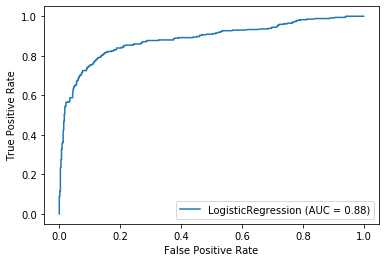

<IPython.core.display.Javascript object>

In [83]:
# Plot ROC curve
plot_roc_curve(log_reg, X_train, y_train)
plt.show()

In [84]:
# Try again with cross validation (to prevent overfitting)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Split test and train datasets using k-fold stratified cv (n=5)
for train_index, test_index in skf.split(X_train, y_train):

    # Split data
    X_cv_train, X_cv_test = X_train.iloc[train_index], X_train.iloc[test_index]
    y_cv_train, y_cv_test = y_train.iloc[train_index], y_train.iloc[test_index]

    # Print scores
    log_reg = LogisticRegression(random_state=42, max_iter=9999)
    log_reg.fit(X_cv_train, y_cv_train)
    tn, fp, fn, tp = confusion_matrix(y_cv_test, log_reg.predict(X_cv_test)).ravel()
    score = (tn + tp) / np.sum([tn, fp, fn, tp])
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    print(
        f"Score: {round(score*100, 1)}% | Precision: {round(precision*100, 1)}% | Recall: {round(recall*100, 1)}%"
    )

Score: 84.4% | Precision: 80.6% | Recall: 78.3%
Score: 83.7% | Precision: 78.3% | Recall: 79.4%
Score: 80.9% | Precision: 77.4% | Recall: 70.6%
Score: 82.6% | Precision: 78.5% | Recall: 75.0%
Score: 84.3% | Precision: 79.7% | Recall: 79.7%


<IPython.core.display.Javascript object>

### Decision Tree

In [85]:
dtc = DecisionTreeClassifier(random_state=42, max_leaf_nodes=10)
dtc.fit(X_train, y_train)

# Print Scores
tn, fp, fn, tp = confusion_matrix(y_train, dtc.predict(X_train)).ravel()
score = (tn + tp) / np.sum([tn, fp, fn, tp])
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)
print(f"Score: {round(score*100, 1)}%")
print(f"Precision: {round(precision*100, 1)}%")
print(f"Recall: {round(recall*100, 1)}%")
print(f"F1: {round(f1*100, 1)}%")

Score: 84.4%
Precision: 78.1%
Recall: 82.5%
F1: 80.2%


<IPython.core.display.Javascript object>

In [86]:
# See coefficients of decision tree
coeff_df = pd.DataFrame(X_train.columns)
coeff_df.columns = ["Feature"]
coeff_df["Correlation"] = pd.Series(dtc.feature_importances_)

coeff_df.sort_values(by="Correlation", ascending=False)

,Feature,Correlation
8,Mr.,0.585453
0,pclass,0.155680
25,big_family,0.085465
1,fare,0.053831
12,Rev.,0.047490
3,age_clean,0.035336
2,has_nickname,0.020413
14,X,0.016332
7,Queensland,0.000000
9,Mrs.,0.000000


<IPython.core.display.Javascript object>

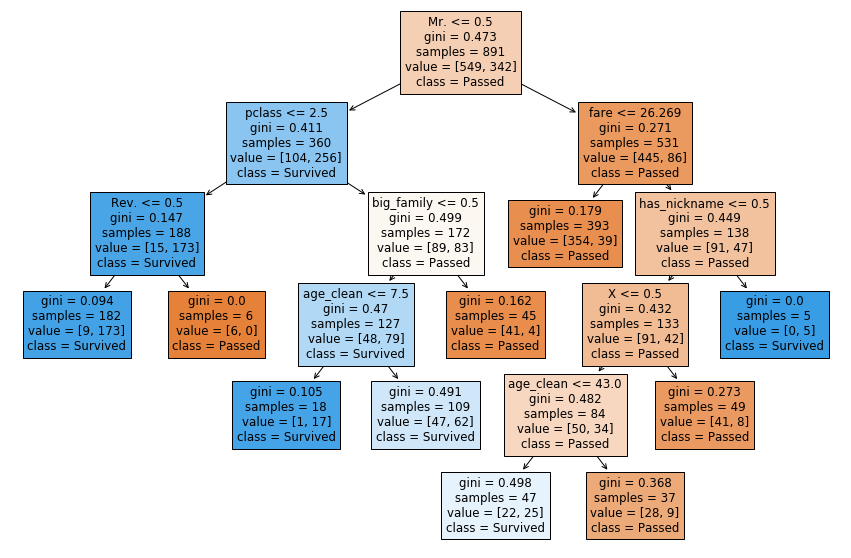

<IPython.core.display.Javascript object>

In [87]:
# export_graphviz(dtc)
fig = plt.figure(figsize=(15, 10))
_ = plot_tree(
    dtc, feature_names=X_train.columns, class_names=["Passed", "Survived"], filled=True
)

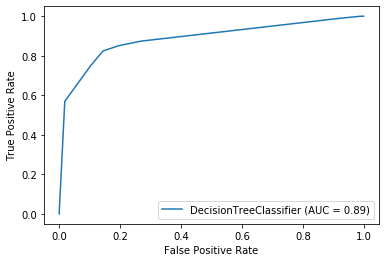

<IPython.core.display.Javascript object>

In [88]:
# Plot ROC curve
plot_roc_curve(dtc, X_train, y_train)
plt.show()

In [89]:
# Try again with cross validation (to prevent overfitting)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Split test and train datasets using k-fold stratified cv (n=5)
for train_index, test_index in skf.split(X_train, y_train):

    # Split data
    X_cv_train, X_cv_test = X_train.iloc[train_index], X_train.iloc[test_index]
    y_cv_train, y_cv_test = y_train.iloc[train_index], y_train.iloc[test_index]

    # Print scores
    dtc = DecisionTreeClassifier(random_state=42)
    dtc.fit(X_cv_train, y_cv_train)
    tn, fp, fn, tp = confusion_matrix(y_cv_test, dtc.predict(X_cv_test)).ravel()
    score = (tn + tp) / np.sum([tn, fp, fn, tp])
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    print(
        f"Score: {round(score*100, 1)}% | Precision: {round(precision*100, 1)}% | Recall: {round(recall*100, 1)}%"
    )

Score: 81.6% | Precision: 77.3% | Recall: 73.9%
Score: 82.0% | Precision: 76.5% | Recall: 76.5%
Score: 74.7% | Precision: 67.2% | Recall: 66.2%
Score: 77.0% | Precision: 70.1% | Recall: 69.1%
Score: 80.9% | Precision: 80.7% | Recall: 66.7%


<IPython.core.display.Javascript object>

### Random Forest

In [90]:
rfc = RandomForestClassifier(random_state=42, max_leaf_nodes=10)
rfc.fit(X_train, y_train)

# Print Scores
tn, fp, fn, tp = confusion_matrix(y_train, rfc.predict(X_train)).ravel()
score = (tn + tp) / np.sum([tn, fp, fn, tp])
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)
print(f"Score: {round(score*100, 1)}%")
print(f"Precision: {round(precision*100, 1)}%")
print(f"Recall: {round(recall*100, 1)}%")
print(f"F1: {round(f1*100, 1)}%")

Score: 83.7%
Precision: 81.7%
Recall: 74.3%
F1: 77.8%


<IPython.core.display.Javascript object>

In [91]:
# See coefficients of random forest
coeff_df = pd.DataFrame(X_train.columns)
coeff_df.columns = ["Feature"]
coeff_df["Correlation"] = pd.Series(rfc.feature_importances_)

coeff_df.sort_values(by="Correlation", ascending=False)

,Feature,Correlation
8,Mr.,0.223365
4,is_male,0.199454
1,fare,0.088140
0,pclass,0.074472
2,has_nickname,0.072940
10,Miss.,0.065963
14,X,0.051940
3,age_clean,0.049460
9,Mrs.,0.043830
25,big_family,0.040810


<IPython.core.display.Javascript object>

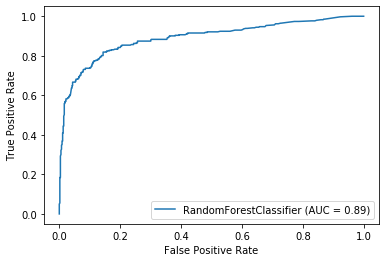

<IPython.core.display.Javascript object>

In [92]:
# Plot ROC curve
plot_roc_curve(rfc, X_train, y_train)
plt.show()

In [93]:
# Try again with cross validation (to prevent overfitting)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Split test and train datasets using k-fold stratified cv (n=5)
for train_index, test_index in skf.split(X_train, y_train):

    # Split data
    X_cv_train, X_cv_test = X_train.iloc[train_index], X_train.iloc[test_index]
    y_cv_train, y_cv_test = y_train.iloc[train_index], y_train.iloc[test_index]

    # Print scores
    rfc = RandomForestClassifier(random_state=42)
    rfc.fit(X_cv_train, y_cv_train)
    tn, fp, fn, tp = confusion_matrix(y_cv_test, rfc.predict(X_cv_test)).ravel()
    score = (tn + tp) / np.sum([tn, fp, fn, tp])
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    print(
        f"Score: {round(score*100, 1)}% | Precision: {round(precision*100, 1)}% | Recall: {round(recall*100, 1)}%"
    )

Score: 82.7% | Precision: 79.7% | Recall: 73.9%
Score: 83.1% | Precision: 77.9% | Recall: 77.9%
Score: 78.1% | Precision: 72.3% | Recall: 69.1%
Score: 78.7% | Precision: 72.1% | Recall: 72.1%
Score: 81.5% | Precision: 79.0% | Recall: 71.0%


<IPython.core.display.Javascript object>

### Support Vector Machine

In [94]:
clf = svm.SVC(random_state=42)
clf.fit(X_train, y_train)

# Print Scores
tn, fp, fn, tp = confusion_matrix(y_train, clf.predict(X_train)).ravel()
score = (tn + tp) / np.sum([tn, fp, fn, tp])
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)
print(f"Score: {round(score*100, 1)}%")
print(f"Precision: {round(precision*100, 1)}%")
print(f"Recall: {round(recall*100, 1)}%")
print(f"F1: {round(f1*100, 1)}%")

Score: 68.6%
Precision: 69.9%
Recall: 31.9%
F1: 43.8%


<IPython.core.display.Javascript object>

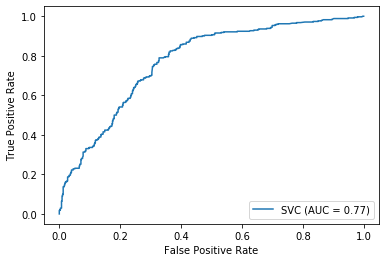

<IPython.core.display.Javascript object>

In [95]:
# Plot ROC curve
plot_roc_curve(clf, X_train, y_train)
plt.show()

In [96]:
# Try again with cross validation (to prevent overfitting)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Split test and train datasets using k-fold stratified cv (n=5)
for train_index, test_index in skf.split(X_train, y_train):

    # Split data
    X_cv_train, X_cv_test = X_train.iloc[train_index], X_train.iloc[test_index]
    y_cv_train, y_cv_test = y_train.iloc[train_index], y_train.iloc[test_index]

    # Print scores
    clf = svm.SVC(random_state=42)
    clf.fit(X_cv_train, y_cv_train)
    tn, fp, fn, tp = confusion_matrix(y_cv_test, clf.predict(X_cv_test)).ravel()
    score = (tn + tp) / np.sum([tn, fp, fn, tp])
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    print(
        f"Score: {round(score*100, 1)}% | Precision: {round(precision*100, 1)}% | Recall: {round(recall*100, 1)}%"
    )

Score: 69.8% | Precision: 75.9% | Recall: 31.9%
Score: 68.5% | Precision: 66.7% | Recall: 35.3%
Score: 66.9% | Precision: 66.7% | Recall: 26.5%
Score: 67.4% | Precision: 70.8% | Recall: 25.0%
Score: 66.9% | Precision: 65.6% | Recall: 30.4%


<IPython.core.display.Javascript object>

The SVM with these given features do not perform as well as the previous models.

## Generate predictions on test set

Out of the 4 models, the Decision Tree had the highest F1 score.

In [97]:
# Get test data
X_test = df.iloc[891:, 1:]

<IPython.core.display.Javascript object>

In [98]:
# Set up submission file
y_test = pd.DataFrame()
y_test["PassengerId"] = X_test.index

<IPython.core.display.Javascript object>

In [101]:
# Use Decision Tree to predict on test data
dtc = DecisionTreeClassifier(random_state=42, max_leaf_nodes=10)
dtc.fit(X_train, y_train)
y_test["Survived"] = pd.Series(dtc.predict(X_test)).astype(int)

<IPython.core.display.Javascript object>

In [102]:
# Export
y_test.to_csv("predictions.csv", index=False, header=True)

<IPython.core.display.Javascript object>

The submitted predictions scored a 74% accuracy on Kaggle. In order to improve the predictions for next time, I could explore different models (e.g. boosted decision tree, KNN), tune parameters of the current models, or create other features. 